In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import odr

In [3]:
def f(p, x):
    """This is a line."""
    return p[0] * x + p[1]

a = 0.5
b = 0.01

beta0 = [a,b]

lin_model = odr.Model(f)

eF = 1. / np.sqrt(1 * a**2) * np.array([1., a])
sigma_pos = 0.1

In [4]:
x = np.linspace(-1, 1)
y = f([a,b], x)

In [5]:
def sample_pseudo_points(n, x_values, sigma_pos, sigma_meas):
    fit_params = []
    for k in range(n):
        points = []
        np.random.seed(k)
        for i, xi in enumerate(x_values):
            sampled_x = np.random.normal(xi, sigma_pos)
            sampled_y = np.random.normal(f([a,b],xi), sigma_pos)
            sampled_sx = np.random.normal(0, sigma_meas[i])
            sampled_sy = np.random.normal(0, sigma_meas[i])
            points.append(
                [sampled_x, sampled_y, sampled_sx, sampled_sy]
            )            
        points = np.asarray(points)
        data = odr.RealData(
            x=points.T[0], 
            y=points.T[1],
            sx=points.T[2],
            sy=points.T[3],
        )
        odr_obj = odr.ODR(data, lin_model, beta0=beta0)
        out = odr_obj.run()
        fit_params.append(
            [out.beta, out.sd_beta]
        )
    return np.asarray(fit_params)


def distance(pseudo_point, target_x):
    """Compute error distance"""
    delta = np.array([0., pseudo_point[1] - f([a,b],target_x)])
    d = delta - (delta @ eF) * eF
    return np.linalg.norm(d)

def sample_distance(fake_points, x_values):
    logL = 0.
    k = 0
    for i, fx in enumerate(fake_points):
        
        logL += ( distance(fx, x_values[k]) / fx[2] ) ** 2
        k += 1
        if k == len(x_values):
            k = 0
    return logL / len(fake_points)

def stupid_metric(sampled_params, target_params):
    mse = 0.
    for sp in sampled_params:
        mse += (sp[0][0] - target_params[0])**2
        mse += (sp[0][1] - target_params[1])**2 
    return mse / len(sampled_params)

def less_stupid_metric(sampled_params, target_params):
    mse = 0.
    for sp in sampled_params:
        mse += (sp[0][0] - target_params[0])**2 / sp[1][0]**2
        mse += (sp[0][1] - target_params[1])**2 / sp[1][1]**2 
    return mse / len(sampled_params)

In [6]:
sampled_fit_params = sample_pseudo_points(
    n=10,
    x_values=x_values[:1],
    sigma_pos=sigma_pos,
    sigma_meas=sigma_meas,
)

stupid_metric(
    sampled_params=sampled_fit_params,
    target_params=beta0,
)

np.float64(0.0)

In [9]:
scaling = []
indices = np.arange(2,10,1)
x_values = np.linspace(-1,1,10)
sigma_meas = [0.01] * 10

for i in indices:
    sampled_fit_params = sample_pseudo_points(
        n=5000,
        x_values=x_values[:i],
        sigma_pos=sigma_pos,
        sigma_meas=sigma_meas[:i],
    )
    scaling.append(less_stupid_metric(
        sampled_params=sampled_fit_params,
        target_params=beta0,
    ))

/tmp/ipykernel_70327/4069976724.py:56: RuntimeWarning: divide by zero encountered in scalar divide
  mse += (sp[0][0] - target_params[0])**2 / sp[1][0]**2
/tmp/ipykernel_70327/4069976724.py:57: RuntimeWarning: divide by zero encountered in scalar divide
  mse += (sp[0][1] - target_params[1])**2 / sp[1][1]**2


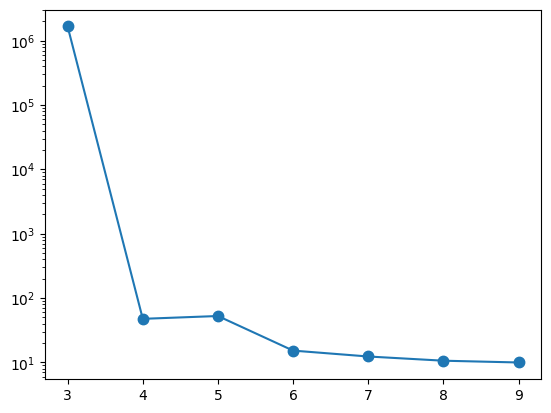

In [10]:
plt.plot(indices, scaling, markersize=15, marker=".")
plt.yscale("log")